<a href="https://colab.research.google.com/github/SnehaDharne/OcularDiseaseRecognition/blob/main/hyp_vgg16_mirnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
import pandas as pd
df_path = '/content/drive/MyDrive/ODIR-5K/balanced_dataset_filled.csv'
df = pd.read_csv(df_path)


In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 7.1 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback
import keras_tuner
from keras_tuner import Hyperband
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.metrics import AUC

# Define custom callback for evaluating metrics
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super(MetricsCallback, self).__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.validation_data
        y_pred = self.model.predict(x_val)
        y_pred_binary = (y_pred > 0.5).astype(int)  # Binary predictions for calculating F1 score
        f1 = f1_score(y_val, y_pred_binary)
        auc = roc_auc_score(y_val, y_pred)
        logs['val_f1'] = f1
        logs['val_auc'] = auc

# Build the model
def build_model(hp):
    # Load pre-trained VGG16 model
    vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the VGG16 base layers
    vgg_base.trainable = False

    # Create the custom top layer
    top_model = keras.Sequential()
    top_model.add(layers.Flatten(input_shape=vgg_base.output_shape[1:]))

    # Define the hyperparameters to tune
    num_layers = hp.Int('num_layers', min_value=2, max_value=4, step=1)
    num_neurons = hp.Int('num_neurons', min_value=128, max_value=512, step=128)

    for _ in range(num_layers):
        top_model.add(layers.Dense(num_neurons, activation='relu'))

    top_model.add(layers.Dense(8, activation='sigmoid'))

    # Combine the base and top layers
    model = keras.Sequential([vgg_base, top_model])

    # Compile the model with the Adam optimizer and custom metrics
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])

    return model

# Create the tuner
tuner = keras_tuner.tuners.Hyperband(
    build_model,
    objective=keras_tuner.Objective("auc", direction="max"),  # Use F1 score as the objective to optimize
    max_epochs=10,
)

data_dir_preprocessed = '/content/drive/MyDrive/ODIR-5K/clahe+mirnet'  # Replace with the path to your preprocessed images
test_image_dir = '/content/drive/MyDrive/ODIR-5K/test-clahe-mirnet'  # Replace with the path to your test images
df['filename'] = ""
df['filename'] = df.apply(lambda row: os.path.join(data_dir_preprocessed, str('clahe_mirnet_'+row['ID'])), axis=1)
batch_size = 64
epochs = 10

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

# Load the training and validation data
 # Replace with the path to your training data file
train_set = df.sample(frac=0.8, random_state=42)
val_set = df.drop(train_set.index)

# Create the flow from dataframe for training and validation sets
train_generator = train_datagen.flow_from_dataframe(dataframe=train_set,
                                                    directory=data_dir_preprocessed,
                                                    x_col="filename",
                                                    y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                           "AMD", "Hypertension", "Myopia", "Others"],
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode="raw",
                                                    shuffle=True)

val_generator = train_datagen.flow_from_dataframe(dataframe=val_set,
                                                  directory=data_dir_preprocessed,
                                                  x_col="filename",
                                                  y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                         "AMD", "Hypertension", "Myopia", "Others"],
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode="raw",
                                                  shuffle=False)
train_steps= len(train_generator)
val_steps = len(val_generator)
# Perform the hyperparameter search
print('everythin is alright')

# model.fit(train_generator, epochs=10, validation_data=val_generator)


58889256/58889256 [==============================] - 0s 0us/step
Found 8249 validated image filenames.
Found 2062 validated image filenames.
everythin is alright


In [ ]:
# Just pass the generator directly to tuner.search
tuner.search(train_generator, epochs=10, validation_data=val_generator)

Trial 18 Complete [00h 17m 48s]
auc: 0.9253576993942261

Best auc So Far: 0.9256632328033447
Total elapsed time: 02h 37m 14s


In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_2 (Sequential)   (None, 8)                 9932936   
                                                                 
Total params: 24,647,624
Trainable params: 9,932,936
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of layers r is {best_hps.get('num_layers')} and the optimal learning rate for the optimizer number of neurons
is {best_hps.get('num_neurons')}.
""")


The hyperparameter search is complete. The optimal number of layers r is 3 and the optimal learning rate for the optimizer number of neurons
is 384.



In [ ]:
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 base layers
vgg_base.trainable = False

# Create the custom top layer
vgg_model = keras.Sequential()
vgg_model.add(layers.Flatten(input_shape=vgg_base.output_shape[1:]))


vgg_model.add(layers.Dense(384, activation='relu'))
vgg_model.add(layers.Dense(384, activation='relu'))
vgg_model.add(layers.Dense(384, activation='relu'))

vgg_model.add(layers.Dense(8, activation='sigmoid'))

# Combine the base and top layers
model = keras.Sequential([vgg_base, vgg_model])

# Compile the model with the Adam optimizer and custom metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_4 (Sequential)   (None, 8)                 9932936   
                                                                 
Total params: 24,647,624
Trainable params: 9,932,936
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
history = model.fit(train_generator, epochs=10, validation_data=val_generator)

# Print the history values
for metric in history.history:
    print(metric, history.history[metric])

# Save the model with the best validation accuracy
]


Epoch 1/10
129/129 [==============================] - 166s 1s/step - loss: 0.3471 - auc: 0.7891 - val_loss: 0.2823 - val_auc: 0.8701
Epoch 2/10
129/129 [==============================] - 156s 1s/step - loss: 0.2715 - auc: 0.8789 - val_loss: 0.2582 - val_auc: 0.8962
Epoch 3/10
129/129 [==============================] - 168s 1s/step - loss: 0.2510 - auc: 0.8979 - val_loss: 0.2666 - val_auc: 0.8902
Epoch 4/10
129/129 [==============================] - 157s 1s/step - loss: 0.2433 - auc: 0.9046 - val_loss: 0.2363 - val_auc: 0.9133
Epoch 5/10
129/129 [==============================] - 159s 1s/step - loss: 0.2338 - auc: 0.9127 - val_loss: 0.2298 - val_auc: 0.9160
Epoch 6/10
129/129 [==============================] - 157s 1s/step - loss: 0.2331 - auc: 0.9138 - val_loss: 0.2252 - val_auc: 0.9197
Epoch 7/10
129/129 [==============================] - 156s 1s/step - loss: 0.2236 - auc: 0.9205 - val_loss: 0.2324 - val_auc: 0.9150
Epoch 8/10
129/129 [==============================] - 158s 1s/step - 

NameError: ignored

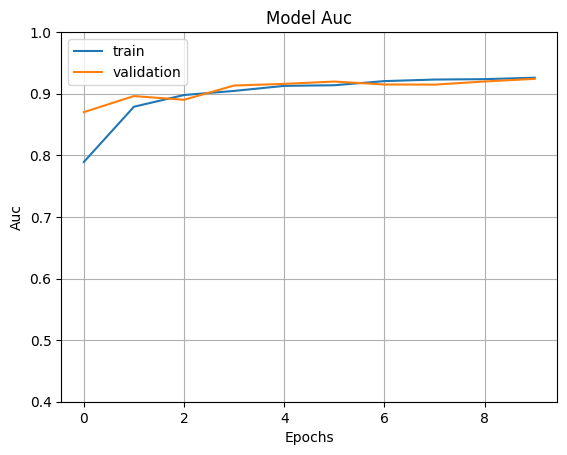

In [ ]:


fig1 = plt.gcf()
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Auc')
plt.ylabel('Auc')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


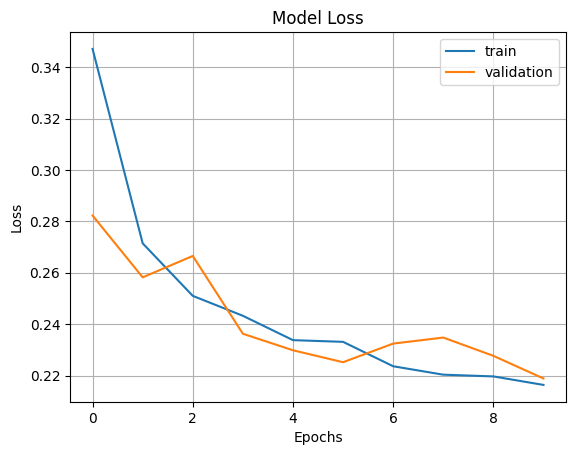

In [ ]:

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
import os
import glob
import numpy as np
# Get the list of image file paths in the test set
test_image_paths = glob.glob(os.path.join(test_image_dir, "*.jpg"))

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["filename", "N", "D", "G", "C",
                                   "A", "H", "M", "O"])

# Load and preprocess each test image
for image_path in test_image_paths:
    filename = os.path.basename(image_path)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make predictions for the image
    predictions = model.predict(img)

    # Create a new row for the results DataFrame
    result_row = {"filename": filename}
    for i, class_name in enumerate(["N", "D", "G", "C",
                                    "A", "H", "M", "O"]):
        result_row[class_name] = predictions[0][i]

    # Append the result row to the DataFrame
    results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 1s 989ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 72ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 56ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 52ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 68ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 69ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 53ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 66ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 55ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 47ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 65ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 70ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 87ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 146ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 111ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 72ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 61ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 81ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 95ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 45ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 106ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 130ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 117ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 72ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 43ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 64ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 95ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 105ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 82ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 75ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 77ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 157ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 74ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - ETA: 0s

<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 80ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)
<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-20-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
df = results_df[~results_df['filename'].str.contains('\(1\)')]

# Display the filtered DataFrame
print(df)


# Sum the probabilities along the row axis
probs = df.iloc[:, 1:].sum(axis=1)

# Display the updated DataFrame
print(probs)

# Step 1: Create 'id' column from filename
df['id'] = df['filename'].str.split('_').str[0]

# Step 2: Remove 'filename' and 'side' columns
df = df.drop(['filename'], axis=1)
grouped_df = df.groupby('id').agg({'N': 'min', 'D': 'max', 'G': 'max', 'C': 'max',
                                   'A': 'max', 'H': 'max', 'M': 'max', 'O': 'max'})

# Display the modified DataFrame
print(grouped_df)

grouped_df.to_csv('hyp-mirnet-vgg16-bal.csv')

            filename         N         D         G         C         A  \
0      1044_left.jpg  0.447438  0.281654  0.021113  0.000525  0.034580   
1      1051_left.jpg  0.516179  0.198551  0.036752  0.000151  0.025681   
2      1076_left.jpg  0.415066  0.322762  0.020474  0.000266  0.034027   
3      1037_left.jpg  0.380323  0.340604  0.048992  0.000368  0.026567   
4      1055_left.jpg  0.528364  0.226800  0.011210  0.000278  0.013368   
...              ...       ...       ...       ...       ...       ...   
1004   1073_left.jpg  0.169825  0.358739  0.006571  0.000217  0.017951   
1005  1055_right.jpg  0.335289  0.444259  0.007626  0.000783  0.058493   
1006   1069_left.jpg  0.361138  0.505958  0.009956  0.000394  0.038105   
1007   1029_left.jpg  0.525991  0.281380  0.006142  0.000190  0.035170   
1008   1049_left.jpg  0.616439  0.196194  0.017640  0.000107  0.011892   

             H         M         O  
0     0.040506  0.000970  0.085244  
1     0.031843  0.000990  0.096649  


<ipython-input-21-d7947fc6b846>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df['filename'].str.split('_').str[0]


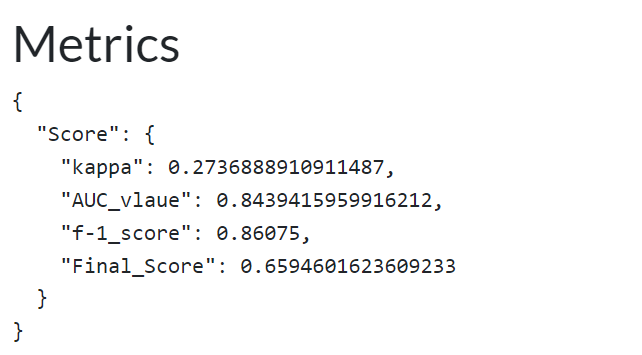

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_4 (Sequential)   (None, 8)                 9932936   
                                                                 
Total params: 24,647,624
Trainable params: 9,932,936
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
data_dir_preprocessed = '/content/drive/MyDrive/archive/ODIR-5K/ODIR-5K/clahe+msr'  # Replace with the path to your preprocessed images
test_image_dir = '/content/drive/MyDrive/archive/test-clahe-msr'  # Replace with the path to your test images
import pandas as pd
df_path = '/content/drive/MyDrive/ODIR-5K/balanced_dataset_filled.csv'
df = pd.read_csv(df_path)
df['filename'] = ""
df['filename'] = df.apply(lambda row: os.path.join(data_dir_preprocessed, str(row['ID'])), axis=1)
batch_size = 64
epochs = 10

# Create an ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True)

# Load the training and validation data
 # Replace with the path to your training data file
train_set = df.sample(frac=0.8, random_state=42)
val_set = df.drop(train_set.index)

# Create the flow from dataframe for training and validation sets
train_generator = train_datagen.flow_from_dataframe(dataframe=train_set,
                                                    directory=data_dir_preprocessed,
                                                    x_col="filename",
                                                    y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                           "AMD", "Hypertension", "Myopia", "Others"],
                                                    target_size=(224, 224),
                                                    batch_size=batch_size,
                                                    class_mode="raw",
                                                    shuffle=True)

val_generator = train_datagen.flow_from_dataframe(dataframe=val_set,
                                                  directory=data_dir_preprocessed,
                                                  x_col="filename",
                                                  y_col=["Normal", "Diabetes", "Glaucoma", "Cataract",
                                                         "AMD", "Hypertension", "Myopia", "Others"],
                                                  target_size=(224, 224),
                                                  batch_size=batch_size,
                                                  class_mode="raw",
                                                  shuffle=False)


Found 8249 validated image filenames.
Found 2062 validated image filenames.


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.metrics import AUC
vgg_base1 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the VGG16 base layers
vgg_base1.trainable = False

# Create the custom top layer
vgg_model1 = keras.Sequential()
vgg_model1.add(layers.Flatten(input_shape=vgg_base1.output_shape[1:]))


vgg_model1.add(layers.Dense(384, activation='relu'))
vgg_model1.add(layers.Dense(384, activation='relu'))
vgg_model1.add(layers.Dense(384, activation='relu'))

vgg_model1.add(layers.Dense(8, activation='sigmoid'))

# Combine the base and top layers
model1 = keras.Sequential([vgg_base1, vgg_model1])

# Compile the model with the Adam optimizer and custom metrics
model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=[AUC(name='auc')])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential_1 (Sequential)   (None, 8)                 9932936   
                                                                 
Total params: 24,647,624
Trainable params: 9,932,936
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
import matplotlib.pyplot as plt
history1 = model1.fit(train_generator, epochs=10, validation_data=val_generator)

# Print the history values
for metric1 in history1.history:
    print(metric1, history1.history[metric1])

Epoch 1/10
129/129 [==============================] - 6893s 53s/step - loss: 0.3498 - auc: 0.7786 - val_loss: 0.3055 - val_auc: 0.8429
Epoch 2/10
 49/129 [==========>...................] - ETA: 54:45 - loss: 0.2911 - auc: 0.8564

In [ ]:


fig1 = plt.gcf()
plt.plot(history1.history['auc'])
plt.plot(history1.history['val_auc'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Auc')
plt.ylabel('Auc')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


In [ ]:

plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()


In [ ]:
import os
import glob
import numpy as np
# Get the list of image file paths in the test set
test_image_paths = glob.glob(os.path.join(test_image_dir, "*.jpg"))

# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=["filename", "N", "D", "G", "C",
                                   "A", "H", "M", "O"])

# Load and preprocess each test image
for image_path in test_image_paths:
    filename = os.path.basename(image_path)
    img = cv2.imread(image_path)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # Make predictions for the image
    predictions = model.predict(img)

    # Create a new row for the results DataFrame
    result_row = {"filename": filename}
    for i, class_name in enumerate(["N", "D", "G", "C",
                                    "A", "H", "M", "O"]):
        result_row[class_name] = predictions[0][i]

    # Append the result row to the DataFrame
    results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 499ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 73ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 88ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 80ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 91ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 95ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 99ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 48ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 191ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 95ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 121ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 62ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 63ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 62ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 44ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 18ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 41ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 93ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 102ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 93ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 46ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 40ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 36ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 37ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 38ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 32ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 23ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 27ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 33ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 35ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 39ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 24ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 67ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 93ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 60ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 26ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 25ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 31ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 28ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 22ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 29ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-30-fb7ffd5263d4>:29: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append(result_row, ignore_index=True)


In [ ]:
import pandas as pd

# Assuming your DataFrame is named 'df'
df = results_df[~results_df['filename'].str.contains('\(1\)')]

# Display the filtered DataFrame
print(df)


# Sum the probabilities along the row axis
probs = df.iloc[:, 1:].sum(axis=1)

# Display the updated DataFrame
print(probs)

# Step 1: Create 'id' column from filename
df['id'] = df['filename'].str.split('_').str[0]

# Step 2: Remove 'filename' and 'side' columns
df = df.drop(['filename'], axis=1)
grouped_df = df.groupby('id').agg({'N': 'min', 'D': 'max', 'G': 'max', 'C': 'max',
                                   'A': 'max', 'H': 'max', 'M': 'max', 'O': 'max'})

# Display the modified DataFrame
print(grouped_df)

grouped_df.to_csv('hyp-msr-vgg16-bal.csv')

            filename         N         D         G         C         A  \
0      1051_left.jpg  0.505564  0.189761  0.016217  0.001020  0.099080   
1      1076_left.jpg  0.452492  0.286786  0.040105  0.006751  0.071759   
2      1037_left.jpg  0.347634  0.245347  0.099111  0.005018  0.030109   
3      1055_left.jpg  0.444219  0.231441  0.052184  0.014238  0.175260   
4     1027_right.jpg  0.391778  0.398522  0.035369  0.004118  0.078418   
...              ...       ...       ...       ...       ...       ...   
1004  1055_right.jpg  0.137190  0.337056  0.009400  0.000451  0.176823   
1005   1069_left.jpg  0.289834  0.362600  0.038736  0.001403  0.109074   
1006   1029_left.jpg  0.489952  0.318406  0.014020  0.002938  0.085016   
1007   1049_left.jpg  0.405476  0.291309  0.008800  0.000690  0.162046   
1008   1044_left.jpg  0.338075  0.281415  0.085465  0.007192  0.055524   

             H         M         O  
0     0.027007  0.007113  0.222225  
1     0.038965  0.006111  0.222366  


<ipython-input-31-1a1ed9a8c6fa>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['id'] = df['filename'].str.split('_').str[0]


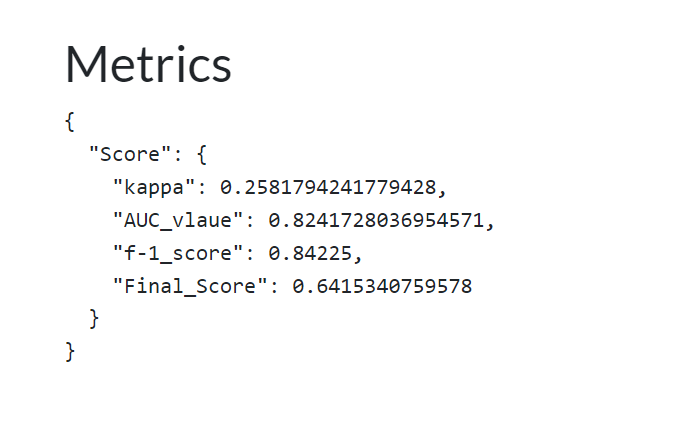